### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Friday, Mar 5th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized!

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. *Also* find the MAP value of the mean.

5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.6 to 5.4.


~6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6\pm0.3$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6$ with standard deviation of $0.3$.~

~7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.~

~8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?~

### Solution

In [1]:
#BS - PRELIMINARIES, IMPORTING PACKAGES AND DATA

# BS - import the things
import numpy as np
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize
from matplotlib import pyplot as plt
import astroML
%matplotlib inline
%config InlineBackend.figure_format='retina'


# BS - import the data using numpy
data_1 = np.load('/Users/smithwj/Box Sync/Astrostatistics/astr_8070_s21/coursework/homeworks/hw_data/hw4_data_1.npy')

voltages = data_1[:,0]
volt_uncerts = data_1[:,1]


#### Part 1

For heteroskedastic Gaussian distributions: 

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

and 

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}$$

In [2]:
#BS - calculate voltage mean
volt_mean = np.sum(voltages / volt_uncerts**2) / np.sum(1 / volt_uncerts**2)

#BS - calculate uncertainty of the mean
volt_mean_uncert = np.sum(1 / volt_uncerts**2)**(-1/2)

print("the voltage mean is {:.4} volts and the uncertaintys on that mean is {:.4} volts.".format(volt_mean, volt_mean_uncert))

the voltage mean is 4.942 volts and the uncertaintys on that mean is 0.4302 volts.


#### Part 2

The ln-likelihood is given by:

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}$$

To find the maximum-likelhiood over one parameter $\mu$, I create a range of possible $\mu$'s, calculate their likelihoods, and find the maximum of that likelihood.

In [3]:
def ln_L_gaussian (mu, sigma_i, x_i):
    
    #BS - definition of the log-likelihood function. 
    ln_L = np.sum((x_i - mu)**2 / (2 * sigma_i**2))
    
    return ln_L

# BS - lambda function helper
likelihood = lambda beta : ln_L_gaussian(mu = beta, sigma_i = volt_uncerts, x_i = voltages)

# BS - take a guess
beta = 3

# BS - optimize! Find that min!
max_likelihood = optimize.fmin(likelihood, beta, disp=False)

print("The value of the mean at the maximum likelihood is {:.3f} volts".format(max_likelihood[0]))


The value of the mean at the maximum likelihood is 4.942 volts


#### Part 3

In [4]:

#BS - probability of a Gaussian for one point (no log)
def P_gaussian (mu, sigma, x_i):
    
    P = (1 / (sigma * np.sqrt(2*np.pi))) * np.exp((-(x_i - mu)**2) / (2*sigma**2))
    return P

# likelihood - product of Gaussians
lkhd = lambda beta : np.prod(P_gaussian(mu=beta, sigma=volt_uncerts, x_i=voltages))
  
# uniform prior between 3 and 7

loc_1 = 3
scale_1 = 4 

def uniform_prior(beta, loc, scale): #BS - remember for self; loc = a, scale = a + width for uniform
    dist = uniform(loc, scale)
    prior = dist.pdf(beta)
    return prior

#BS - create grid of mu values to sample over
mu_dist = np.linspace(0, 10, 100)

#BS --- calculate each posterior probability as likelihood * prior ---

#BS - array to store each post prop
post_probs_uni_1 = []

#BS - loop over each value of mu, calculate the post prob, and append it
for i in range(len(mu_dist)):
    
    post_prob = lkhd(mu_dist[i])*uniform_prior(mu_dist[i], loc_1, scale_1)
    post_probs_uni_1.append(post_prob)

#BS - numpy housekeeping
post_probs_uni_1 = np.array(post_probs_uni_1)


#BS - norm constant - find out what the integral is over the un-normalized
# posterior distribution. One divided by that will give the normalization
# constant such that the posterior distribution will be normalized
dx = mu_dist[1] - mu_dist[0]
A = np.sum(post_probs_uni_1 * dx)
norm_const = 1 / A
norm_post_probs = norm_const *  post_probs_uni_1

#BS - will be plot in part 7!



As for the logic of normalization, recall Bayes:

$$p(M\,|\,D) = \frac{p(D\,|\,M)\,p(M)}{p(D)},$$

where $D$ is for data and $M$ is for model. Or in words,

$${\rm Posterior \,\, Probability} = \frac{{\rm Likelihood}\times{\rm Prior}}{{\rm Evidence}}.$$

If we explicitly recognize prior information, $I$, and the model parameters, $\theta$, then we can write:

$$p(M,\theta \,|\,D,I) = \frac{p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)}{p(D\,|\,I)},$$

written another way, letting ${p(D\,|\,I)} = {\rm evidence}$:

$${\rm evidence} \times p(M,\theta \,|\,D,I) = p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I)$$

The thing I have calculated in the cell above to geth the posterior is the right hand side of the equation, the likelihood times the prior. Even though I'm just calling this the posterior in my code, it is actually the un-normalized posterior times the evidence. To find the normalization factor, I have to be a bit less careless in my quantities.

If I integrate:

$$ \int {\rm evidence} \times p(M,\theta \,|\,D,I) d\theta = \int p(D\,|\,M,\theta,I)\,p(M,\theta\,|\,I) d\theta$$



For a probability distribution to be normalized:

$$ \int P(x)dx = 1$$


Since I have the values for the following distribution (since it is equal to the right hand side):

$${\rm evidence} \times  p(M,\theta \,|\,D,I)$$

I can 'integrate' that to get:

$$ \int {\rm evidence} \times p(M,\theta \,|\,D,I) d\theta = A $$

I can find $A$ such that:

$$\int \frac{{\rm evidence}}{A} \ \times p(M,\theta \,|\,D,I) d\theta = 1$$

or 

$$ \int p(M,\theta \,|\,D,I) d\theta = \frac{A}{{\rm evidence}}$$

where A is just some number that my integral is equal to. But this means that 

$$\int p(M,\theta \,|\,D,I) d\theta =1 $$ when $${\rm evidence} = A$$

Since the thing I started with, though, is ($A \times {\rm normalized \ posterior}$) to get just the normalized posterior, I have to divide by $A$.


#### Part 4

The 68% credible region for the mean is 4.444 to 5.354
This is compared to the 68% confidence interval of 4.512 to 5.372
The maximum a posteriori estimation of the mean is 4.949


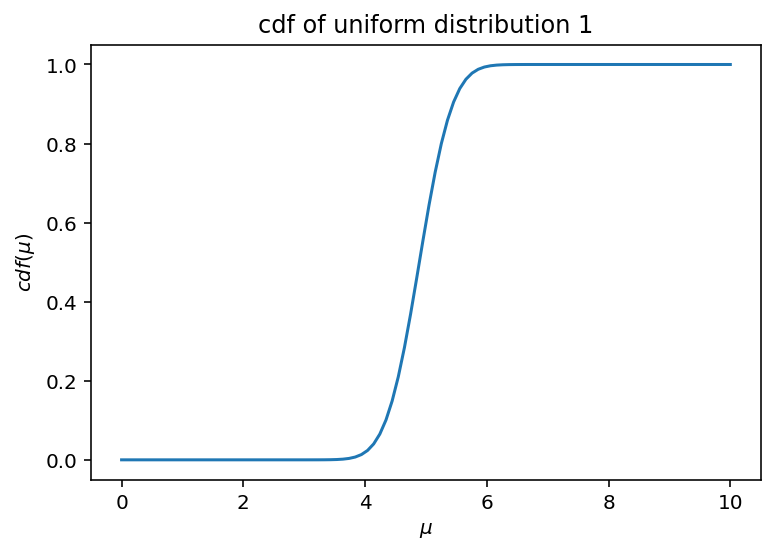

In [5]:
# BS - I'm going with the cdf method!

# BS - calculate the cdf as a cumulative sum (thanks for the dx reminder)
cdf_uni_1 = np.cumsum(norm_post_probs*dx)

# BS - function that takes the pct (say .68 for 68%) and returns the
# percentiles for the two spots on the equi-tailed distribution 
def tail_splitter(pct):
    
    cut_val_low = (1 - pct)/2
    cut_val_high = 1 - cut_val_low
    
    return cut_val_low, cut_val_high

# BS - get values for 68%
low, high = tail_splitter(0.68)

# BS - quick function that finds, for a given a value, the nearest value
# in an array to that value
def nearest(array, value):
    
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

# BS - from the cdf, find the nearest points to the values from the tailsplitter
# for a 68% interval
low_pt, low_pt_idx = nearest(cdf_uni_1, low)
high_pt, high_pt_idx = nearest(cdf_uni_1, high)

# BS - Find the values of mu that correspond to these parts of the cdf
mu_low_68 = mu_dist[low_pt_idx]
mu_high_68 = mu_dist[high_pt_idx]

print("The 68% credible region for the mean is {:.3f} to {:.3f}".format(mu_low_68, mu_high_68))
int_message = "This is compared to the 68% confidence interval of {:.3f} to {:.3f}".format(volt_mean - volt_mean_uncert, volt_mean + volt_mean_uncert)
print(int_message)

# BS - find the MAP as the maximum value of mu from the posterior distribution
MAP = mu_dist[post_probs_uni_1.argmax()]

print("The maximum a posteriori estimation of the mean is {:.3f}".format(MAP))

#BS - Note on the difference between the credible region and confidence interval. I'm fairly certain
# this merely has to do with the how few grid points in mu I have samples over, and with many more 
# grid points, my uncertainties should and would match (I tried it with 10,000 instead of 100 and 
# the intervals were equal to within two decimal places)

#BS - additionally, you didn't ask for the cdf, but it feels negligent to not include it
# Granted, I didn't spend as much time sprucing it up.
plt.plot(mu_dist, cdf_uni_1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$cdf(\mu)$')
plt.title("cdf of uniform distribution 1")
plt.show()

#### Part 5

In [6]:
# BS - This is the same process as above just with the different uniform prior
# if I had more time I would 'functinalize' this code instead of copying and pasting so much

loc_2 = 4.6
scale_2 = 5.4 - 4.6 

post_probs_uni_2 = []

# BS - loop over each value of mu, calculate the post prob, and append it
for i in range(len(mu_dist)):
    
    post_prob = lkhd(mu_dist[i])*uniform_prior(mu_dist[i], loc_2, scale_2)
    post_probs_uni_2.append(post_prob)

# BS - numpy housekeeping
post_probs_uni_2 = np.array(post_probs_uni_2)


# BS - normalize
B = np.sum(post_probs_uni_2 * dx)
norm_const_2 = 1 / B
norm_post_probs_2 = norm_const_2 *  post_probs_uni_2

# BS - CDF
cdf_uni_2 = np.cumsum(norm_post_probs_2*dx)


# BS - find credible regions
low_pt2, low_pt_idx2 = nearest(cdf_uni_2, low)
high_pt2, high_pt_idx2 = nearest(cdf_uni_2, high)

mu_low_68_2 = mu_dist[low_pt_idx2]
mu_high_68_2 = mu_dist[high_pt_idx2]

# BS - find MAP
MAP2 = mu_dist[post_probs_uni_1.argmax()]

print("The 68% credible region for the mean is {:.3f} to {:.3f}".format(mu_low_68_2, mu_high_68_2))
print(int_message)
print("The maximum a posteriori estimation of the mean is {:.3f}".format(MAP))


The 68% credible region for the mean is 4.646 to 5.152
This is compared to the 68% confidence interval of 4.512 to 5.372
The maximum a posteriori estimation of the mean is 4.949


#### Part 6

In [7]:
##Gaussian Prior

# BS - function to define the prior
def gaussian_prior(beta, loc=6, scale=0.3): 
    dist = norm(loc, scale)
    prior = dist.pdf(beta)
    #print(beta, prior)
    return prior


# BS - make my empty array to fill with post probs
post_probs_gauss = []

# BS - loop over each mu, calculate the likelihood, multipy by prior, and append
for i in range(len(mu_dist)):
    
    post_prob = lkhd(mu_dist[i])*gaussian_prior(mu_dist[i])
    post_probs_gauss.append(post_prob)

# BS - numpy housekeeping
post_probs_gauss = np.array(post_probs_gauss)

# BS - Normalize
C = np.sum(post_probs_gauss * dx)
norm_const_3 = 1 / C
norm_post_probs_gauss = norm_const_3 * post_probs_gauss

# BS - cdf
cdf_gauss = np.cumsum(norm_post_probs_gauss*dx)


# BS find the intervals from the cdf
low_pt_gs, low_pt_idx_gs = nearest(cdf_gauss, low)
high_pt_gs, high_pt_idx_gs = nearest(cdf_gauss, high)

mu_low_68_gs = mu_dist[low_pt_idx_gs]
mu_high_68_gs = mu_dist[high_pt_idx_gs]


# BS - calculate the MAPS
MAP_gs = mu_dist[norm_post_probs_gauss.argmax()]

print("The 68% credible region for the mean is {:.3f} to {:.3f}".format(mu_low_68_gs, mu_high_68_gs))
print(int_message)
print("The maximum a posteriori estimation of the mean is {:.3f}".format(MAP_gs))

The 68% credible region for the mean is 5.354 to 5.859
This is compared to the 68% confidence interval of 4.512 to 5.372
The maximum a posteriori estimation of the mean is 5.657


#### Part 7

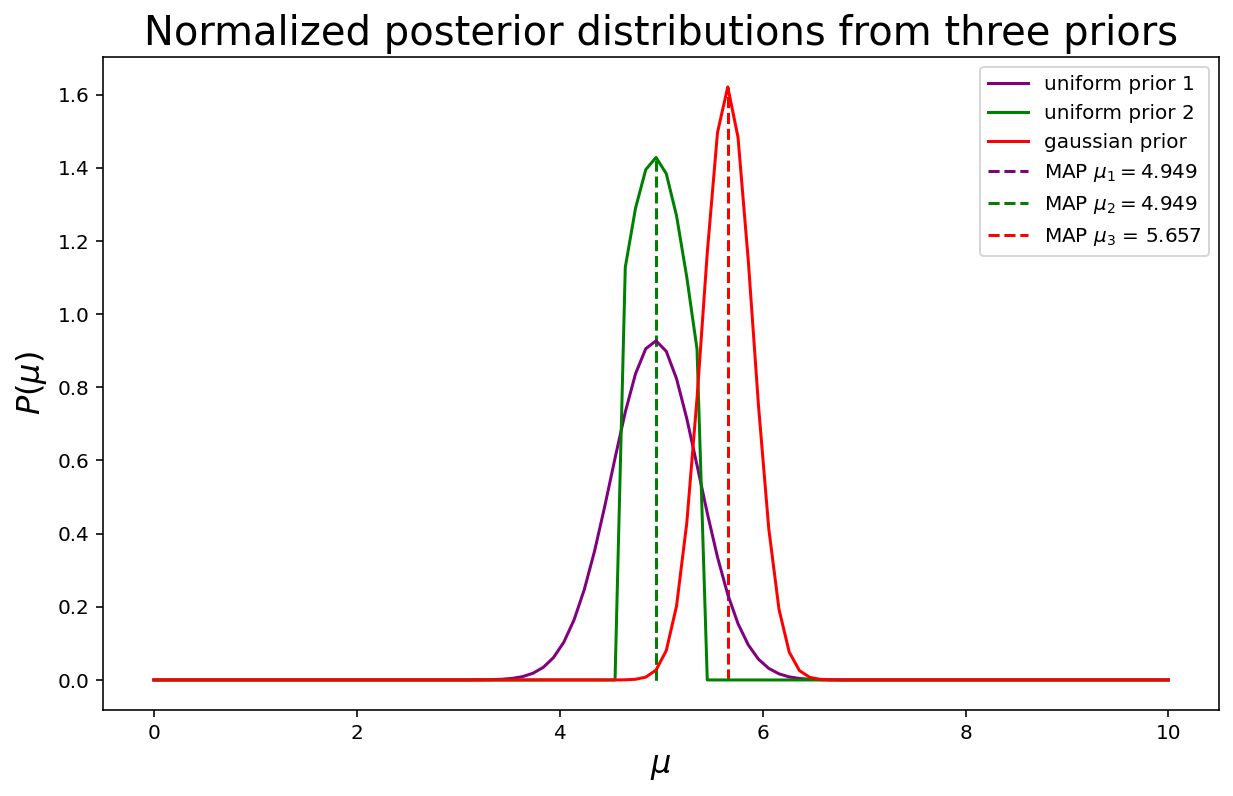

In [8]:
# BS - plot all three distributions. dotted lines are the MAPS (purple is hiding under green)

plt.subplots(figsize=(10,6))
plt.plot(mu_dist, norm_post_probs, color = 'purple', label="uniform prior 1")
plt.plot(mu_dist, norm_post_probs_2, color = 'green', label='uniform prior 2')
plt.plot(mu_dist, norm_post_probs_gauss, color = 'red', label="gaussian prior")
plt.vlines(MAP, 0, norm_post_probs.max(), linestyle='dashed', color='purple', label=r"MAP $\mu_{1} = %.3f$" % MAP)
plt.vlines(MAP2, 0, norm_post_probs_2.max(), linestyle='dashed', color='green', label=r"MAP $\mu_{2} = %.3f$" % MAP2)
plt.vlines(MAP_gs, 0, norm_post_probs_gauss.max(), linestyle='dashed', color='red', label=r"MAP $\mu_{3}$ = %.3f" % MAP_gs)
plt.title("Normalized posterior distributions from three priors", fontsize = 20)
plt.xlabel(r"$\mu$", fontsize = 16)
plt.ylabel(r"$P(\mu)$", fontsize = 16)
plt.legend(loc='best')
plt.show()


#### Part 8

In [9]:

def delta_prior(volt_mean, mu_dist, mu_dist_indiv):

    #BS - There may be a better way to do this, but it gets the job done.
    # 1. Because of discreteness, find the nearest mean in the mu grid
    # to the true voltage mean.
    # 2. See if that mean matches the mean of the likelihood we are
    # calculating, set the prior to be equal to one.
    # 3. Otherwise, set the prior equal to zero.
    # The prior will be zero everywhere except where the mean = the max mean (discretely)
    # at that point it will be one. Thus, once the prior is multiplied by the 
    # likelihood, it will return a zero for the posterior everywhere except 
    # the max mean, at which point it will return the likelihood for mean
    # at that point. 
    
    nearest_mean, nearest_mean_idx = nearest(mu_dist, volt_mean)
    
    if nearest_mean == mu_dist_indiv:
        
        delta_prior = 1
        
    else:
        
        delta_prior = 0
        
    return delta_prior


#BS - calculate the posterior as before (I know I'm appending a lot of zeros, but
# the arrays are small and I didn't want to take any short cuts)
post_probs_delta=[]

for i in range(len(mu_dist)):
    
    post_prob = lkhd(mu_dist[i])*delta_prior(volt_mean, mu_dist, mu_dist[i])
    post_probs_delta.append(post_prob)

post_probs_delta = np.array(post_probs_delta)

# BS - calculate the evidence
D = np.sum(post_probs_delta * dx)
norm_const_4 = 1 / D
norm_post_probs_delta = norm_const_4 * post_probs_delta

# BS - calculate the Bayes ratio (uniform 1 / Delta)
Bayes_ratio = A / D

# BS - note: table in lecture 9 uses ln(Beta) for Bayes factor analysis
Bayes_ln = np.log(Bayes_ratio)

print("The natural log of the Bayes ratio of the evidence for the uniform prior over the delta prior is {:.3}".format(Bayes_ln))
print("According to the tabel in lecture 9, this favors the uniform model to a degree that is 'barely worth mentioning'. ")
print("Which is odd to me intuitively. I would have figured the delta would be preferred with the uniform not penalized very heavily.")
    

The natural log of the Bayes ratio of the evidence for the uniform prior over the delta prior is 0.982
According to the tabel in lecture 9, this favors the uniform model to a degree that is 'barely worth mentioning'. 
Which is odd to me intuitively. I would have figured the delta would be preferred with the uniform not penalized very heavily.


## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`.~

We're going to do some polynomial fits to this data just like in the lecture. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

In [10]:

#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta)) #BS - enumerate function returns both (count, value) for each
                                                          #iteration of the loop. Looping over theta (n, t) = counter, theta[counter]

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension.

5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in the lecture? 

### Solution

#### Part 1

In [11]:

#BS - import the data and assign

data_2 = np.load('/Users/smithwj/Box Sync/Astrostatistics/astr_8070_s21/coursework/homeworks/hw_data/hw4_data_2.npy')

x, y, sigma_y = data_2


#### Part 2

In [12]:

# BS - make ranges for my parameters. theta 0 is constant, theta 1 is
# range of slopes for linear model

theta_0 = -0.23
theta_1 = np.linspace(0,10,100)

# BS - empty array for likelihoods
likelihoods_lin = []

# BS - loop through each potential slope parameter, calculate likelihood
# using both constant theta_0 and varying theta_1 and append
for i in range(len(theta_1)):
    
    theta = np.array([theta_0, theta_1[i]])
    likelihood = logL(theta, data_2, model=polynomial_fit)
    likelihoods_lin.append(likelihood)

# BS - calculate the prior for slope parameter
prior_lin = uniform_prior(theta_1, loc=0.5, scale=1)

# BS - calculate the posterior probability distribution. Reminder that
# they need to be log*log or regular*regular. I chose the latter.
post_probs = np.exp(likelihoods_lin) * prior_lin

# BS - integrate to calculate the Bayesian evidence
dx = theta_1[1] - theta_1[0]
D = np.sum(post_probs * dx)

print("Bayesian evidence for the linear model is {}.".format(D))
print("This is indeed a big number.")


Bayesian evidence for the linear model is 368579480.17141974.
This is indeed a big number.


#### Part 4

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


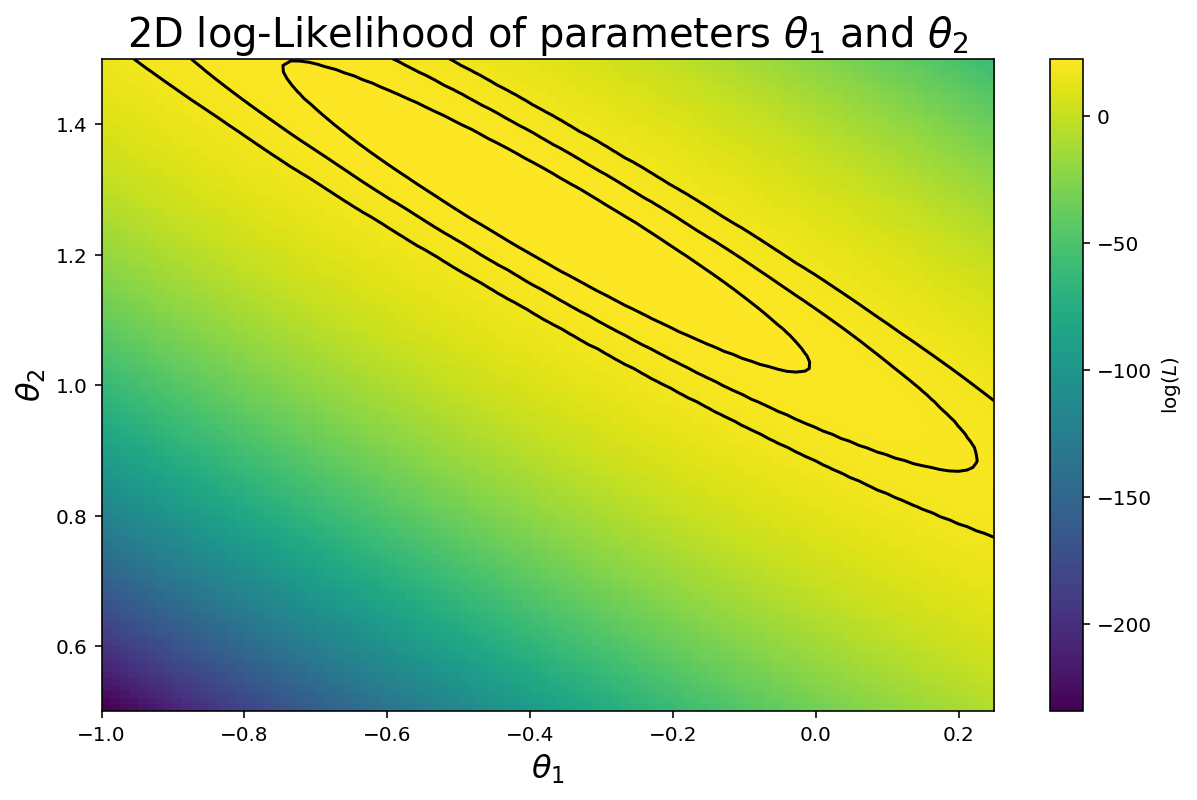

In [13]:
# BS - Time for a two parameter model. Theta_1 is linear terma and 
# theta_2 is quadratic term. I am deliberately sampling them over a much
# smaller parameter space given that I know the uniform priors I will be
# using.

theta_1 = np.linspace(0.5, 1.5, 100)
theta_2 = np.linspace(-1, 0.25, 100)

# BS - To calculate the likelihoods, I need to calculate 
# the likelihoods of every combination of theta_1 and 
# theta_2. This 'mesh' takes my two parameter arrays (of length N) above
# and gives me an (N^2 x 2) array where each row is a combination of 
# theta_1 and theta_2
mesh = np.array(np.meshgrid(theta_1, theta_2))
combinations = np.array(mesh.T.reshape(-1, 2))

#BS - empty array to store all of the posteriors
posteriors_linquad = []

# BS - loop through the combination array. For each row
# take theta_1 and theta_2, combine it with the constant theta_0, 
# and calculate the likelihood. Then calculate each of the priors
# for each of the two parameters from their respective uniform
# distributions. Then, multiply the likelihood by each prior to 
# get the posterior for that combination of parameter values.
for i in range(len(combinations)):
    
    # BS - extra _ so my arrays above don't get reassigned
    theta__1 = combinations[i,0]
    theta__2 = combinations[i,1]
    
    theta_quad = np.array([theta_0, theta__1, theta__2])

    likelihood_quad = logL(theta_quad, data_2, model=polynomial_fit)
    
    prior_lin = uniform_prior(theta__1, 0.5, 1)
    prior_quad = uniform_prior(theta__2, -1, 1.25)
    
    # BS - quad likelihood function above calculetes ln(likelihood)
    # have to exp() it to line up with priors. 
    posterior_linquad = np.exp(likelihood_quad) * prior_lin * prior_quad
    
    posteriors_linquad.append(posterior_linquad)
    
# BS - numpy housekeeping
ln_posteriors_linquad = np.log(np.array(posteriors_linquad))

# BS - reshapes teh posteriors for the plotting below
ln_posteriors_linquad = np.reshape(ln_posteriors_linquad, (100, 100))

# BS - to draw the contours (following the example in lecture 9)
from astroML.plotting.mcmc import convert_to_stdev


plt.subplots(figsize=(10,6))
# BS - make the heatmap 
plt.imshow(ln_posteriors_linquad, aspect='auto', origin='lower',
           extent=(theta_2.min(), theta_2.max(), theta_1.min(), theta_1.max()))
plt.colorbar().set_label(r'$\log(L)$')
# BS - make the 68, 95, 99.7 contours (BLACK CONTOUR LINES)
# Note - I couldn't figure out how to add these to the legend
plt.contour(theta_2, theta_1, convert_to_stdev(ln_posteriors_linquad),
           levels=(0.683, 0.955, 0.997), colors='black')
plt.xlim(-1.0, 0.25)
plt.ylim(0.5, 1.5)
plt.xlabel(r"$\theta_{1}$", fontsize=16)
plt.ylabel(r"$\theta_{2}$", fontsize=16)
plt.title(r"2D log-Likelihood of parameters $\theta_{1}$ and $\theta_{2}$", fontsize=20)
plt.show()


# BS - I'm still not sure I did this entirely correctly. Mainly I am concerned about how the
# values appear to be cut off even though it goes (in theory) right to the edge of the
# non-zero parameter space.



#### Part 5

In [14]:
# BS - integrate to find the Evidence. Need to dx's because we are integrating over two
# parameters in two dimensions

dx_1 = theta_1[1] - theta_1[0]
dx_2 = theta_2[1] - theta_2[0]

posteriors_linquad = np.array(posteriors_linquad)

E = np.sum(posteriors_linquad*dx_1*dx_2)

print("The evidence for the quadratic model is {}".format(E))
print("Also a fairly sizeable number.")

The evidence for the quadratic model is 493061001.65705675
Also a fairly sizeable number.


#### Part 6

In [15]:
#BS - ratio of quad / linear

print("Bayes factor is {:.5}".format(np.log(E/D)))
print("Given this Bayes factor, the quadratic model is 'slightly' preferred.")
print("In comparison, the BIC analysis favored the linear model, as the quadratic")
print("model fit slightly better though this was outweighted by the exra parameter penalty.")

Bayes factor is 0.29098
Given this Bayes factor, the quadratic model is 'slightly' preferred.
In comparison, the BIC analysis favored the linear model, as the quadratic
model fit slightly better though this was outweighted by the exra parameter penalty.
